## Importations

In [2]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

##
import seaborn as sns

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [40]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_triarylboranes = df_total[df_total.group == "triarylboranes"]

## Generate SMILES

In [41]:
all_possible_smiles = []
smi_base = 'C1(*)=C(*)C(*)=C(*)C(*)=C1B(C2=C(*)C(*)=C(*)C(*)=C2*)C3=C(*)C(*)=C(*)C(*)=C3*' #triarylboranes 
frags = ['N', 'O', 'Cl', 'F', 'Br', 'C', 'OC', 'N(C)C',
          '[H]',"C#N", "C(C)(C)C", "C(F)(F)F","[N+]([O-])=O"]
for frag in frags :
    L = list(smi_base)
    L[3]=L[21]=L[33]=L[51]=L[58]=L[76]= frag
    for frag2 in frags :
        L[8] = L[17] = L[37] = L[46] = L[62] = L[71] = frag2
        for frag3 in frags :
            L[12] = L[42] = L[67] = frag3
            new_L = "".join(L)
            mol  = Chem.MolFromSmiles(new_L)
            smi = Chem.MolToSmiles(mol)
            all_possible_smiles.append(smi)   

In [41]:
df_all_smiles = pd.DataFrame()
df_all_smiles['SMILES']= all_possible_smiles
df_all_smiles = df_all_smiles.set_index('SMILES')
df_all_smiles.to_csv('../tables/data/all_possible_smiles_triarylboranes.csv')

In [42]:
# Load data
df = pd.read_csv('../tables/data/all_possible_smiles_triarylboranes.csv')
all_smiles = df['SMILES'].values

In [43]:
not_in_DB_smi = [smi for smi in all_smiles if smi not in df_triarylboranes.index]

## Featurize molecules

In [44]:
def compute_ECFP(smiles_list, radius=2, nBits=2048):
    """Compute ECFP fingerprints for a list of SMILES strings."""
    fingerprints = []
    for sm in smiles_list:
        molecule = Chem.MolFromSmiles(sm)
        if molecule:
            ecfp_fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits)
            fingerprint_bits = np.array(ecfp_fingerprint)
            fingerprints.append(fingerprint_bits)
        else:
            print(f"Invalid SMILES string: {sm}")
            fingerprints.append(np.zeros(nBits, dtype=int))
    return np.array(fingerprints)

In [46]:
all_fingerprints = compute_ECFP(all_smiles)

In [47]:
df_fingerprints = pd.DataFrame(all_fingerprints)

df_clusters = pd.concat([df, df_fingerprints], axis=1)

## K-means clustering

In [48]:
n_clustering = 1 #number of repeat of K-means clustering, 10 is good

n_clusters = 100 # number of molecules to select using clustering
n_init = 10 # can reduce this to save time

for i in range(n_clustering):
    km = KMeans(n_clusters=n_clusters, n_init=n_init)
    km.fit(all_fingerprints)
    df_clusters[str(i)] = km.labels_ # add cluster labels to the dataframe
    selected_smiles = []
    
    for cluster_id in sorted(df_clusters[str(i)].unique()):
        cluster_data = df_clusters[df_clusters[str(i)] == cluster_id].iloc[:,0:2049]
        centroid = km.cluster_centers_[cluster_id]
        cluster_data_not_in_DB = cluster_data[cluster_data['SMILES'].isin(not_in_DB_smi)]
        
        distances = np.linalg.norm(cluster_data_not_in_DB.iloc[:, 1:].values - centroid, axis=1)
        representative_smi = cluster_data_not_in_DB.iloc[np.argmin(distances)]['SMILES'] # look for the molecule closer to the centroid that 
                                                                                         # is not already in the DB
        
        selected_smiles.append(representative_smi)
    
    df_kmeans = pd.DataFrame()
    df_kmeans['SMILES']=selected_smiles
    df_kmeans.to_csv(f'../tables/data/K-means/triarylboranes_kmeans_100_{i}.csv')
    

#clusters_df['selected'] = clusters_df['SMILES'].apply(lambda x: 1 if x in selected_smiles else 0)

#pd.DataFrame({'SMILES': selected_smiles}).to_csv('selected_kmeans.csv', index=False)

### Analyze all K-means clustering results

In [49]:
kmeans_0 = pd.read_csv('../tables/data/K-means/triarylboranes_kmeans_100_0.csv')

In [50]:
all_kmeans = pd.DataFrame()
all_kmeans["0"]= kmeans_0["SMILES"]

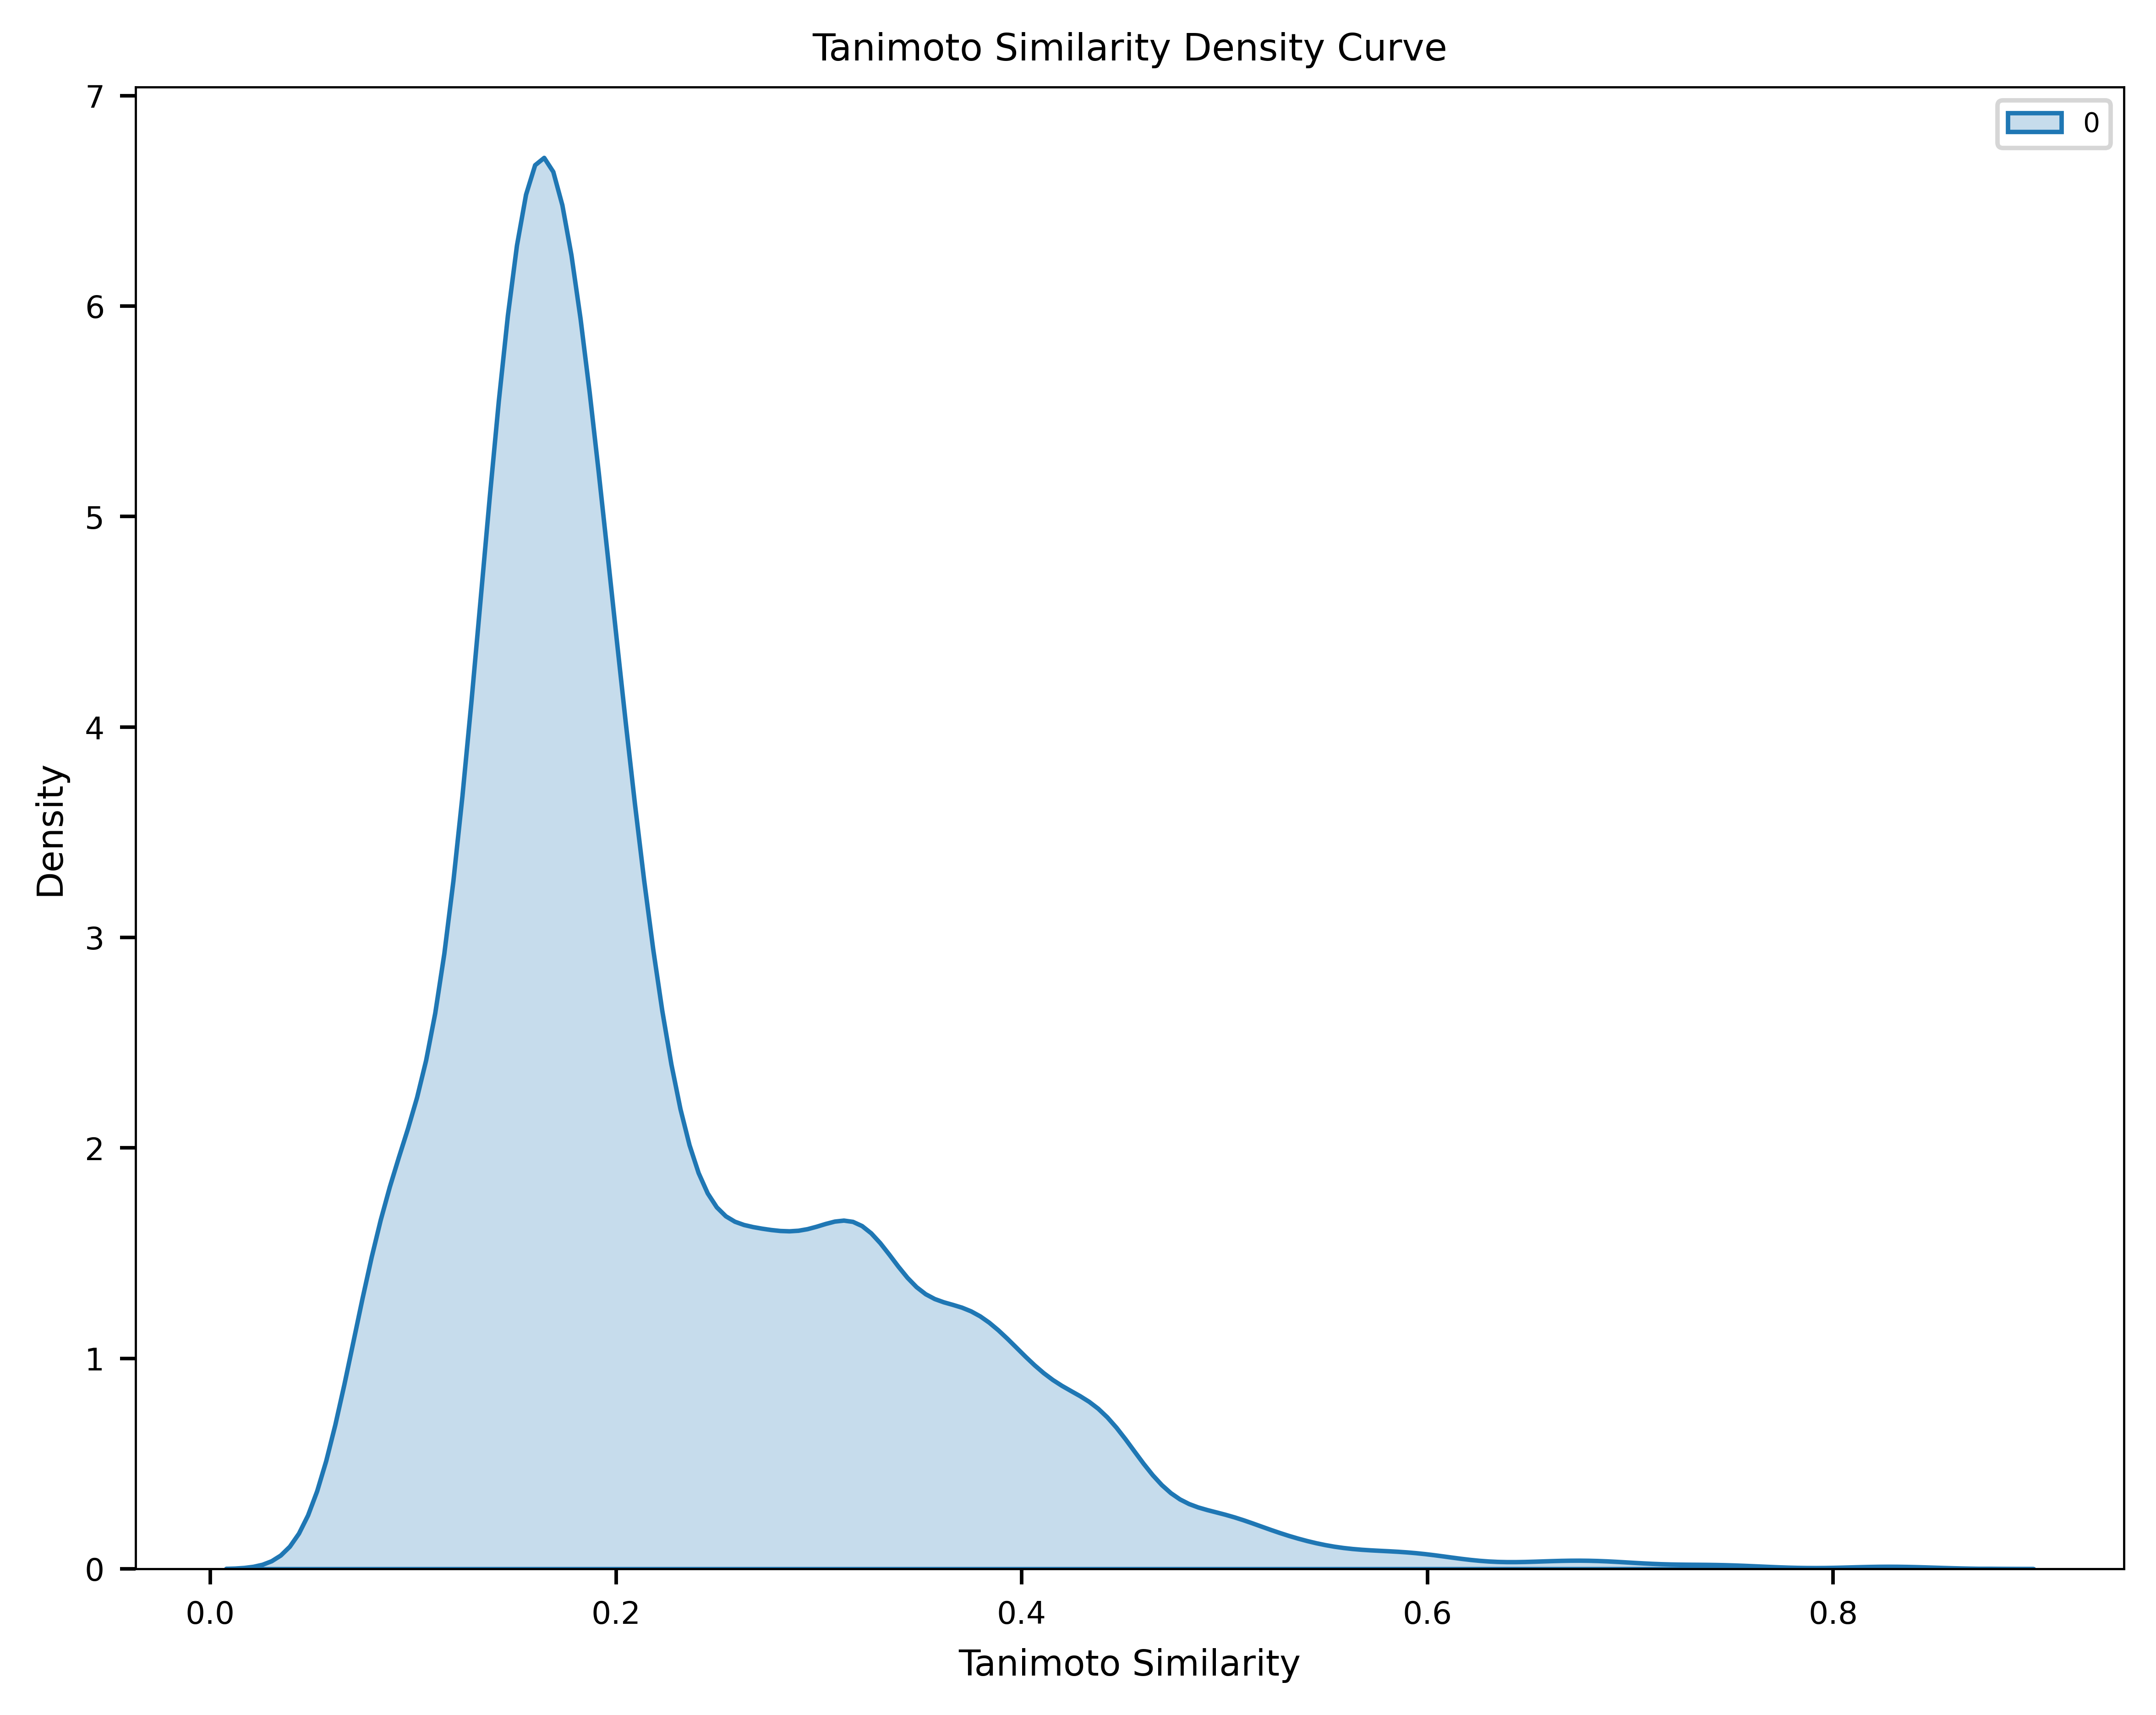

In [51]:
plt.figure(figsize=(8, 6))

for col in all_kmeans.columns :
    
    smiles_list = all_kmeans[col]
    
    # Calculate Morgan fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in smiles_list]

    # Calculate Tanimoto similarities
    similarity_matrix = []
    for i in range(len(smiles_list)):
        similarities = [AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(len(smiles_list))]
        similarity_matrix.append(similarities)

    # Create a DataFrame for the similarity matrix
    df = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)

    # Flatten the upper triangle of the similarity matrix for the kernel density estimate
    flat_similarity_values = df.values[np.triu_indices(len(smiles_list), k=1)]

    # Create a density curve

    sns.kdeplot(flat_similarity_values, fill=True, label = f'{col}')
    
plt.title("Tanimoto Similarity Density Curve")
plt.xlabel("Tanimoto Similarity")
plt.legend()
plt.ylabel("Density")
plt.show()

## Save selected smiles

In [60]:
df_all_kmeans = pd.concat([kmeans_0, kmeans_1])

In [76]:
df = pd.DataFrame()
df['SMILES'] = df_all_kmeans['SMILES'].value_counts()[:50].keys() # get the 50 more represented smiles accross running the K-means algo

In [78]:
df.to_csv('../tables/data/K-means/50_smi_to_run_triarylboranes_kmeans.csv')

## Represent data

In [71]:
X_embedded_all = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(all_fingerprints)

In [79]:
df_selected_kmeans = pd.read_csv('../tables/data/K-means/50_smi_to_run_triarylboranes_kmeans.csv')

In [100]:
smi = df_selected_kmeans.at[0,  'SMILES']

In [103]:
smi in list(df_selected_kmeans['SMILES'])

True

In [107]:
indexes_kmeans = []
for i, smi in enumerate(all_smiles):
    if smi in list(df_selected_kmeans['SMILES']):
        indexes_kmeans.append(i)

In [108]:
df_X_embedded_all = pd.DataFrame(X_embedded_all)
df_X_embedded_kmeans = df_X_embedded_all.iloc[indexes_kmeans]

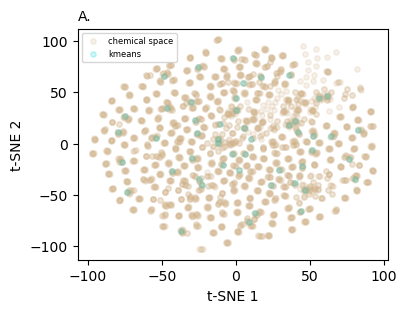

In [109]:
fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot()

ax.scatter(X_embedded_all[:,0], X_embedded_all[:,1], c = 'tan', s = 15, alpha = 0.2, marker = "o", label = 'chemical space')
ax.scatter(df_X_embedded_kmeans[0], df_X_embedded_kmeans[1], c = 'darkturquoise', s = 15,  alpha = 0.2, marker = 'o', label = 'kmeans')


plt.legend(loc = 'best', fontsize = 6)
plt.ylabel('t-SNE 2')
plt.xlabel('t-SNE 1')
ax.set_title('A.', loc='left', fontsize =10)
plt.show()


### Plot similarities for ONO scaffold

In [53]:
kmeans_0 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_0.csv')
kmeans_1 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_1.csv')
kmeans_2 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_2.csv')
kmeans_3 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_3.csv')
kmeans_4 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_4.csv')
kmeans_5 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_5.csv')
kmeans_6 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_6.csv')
kmeans_7 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_7.csv')
kmeans_8 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_8.csv')
kmeans_9 = pd.read_csv('../tables/data/K-means/kmeans_50_2000init_max1000iter_9.csv')

In [54]:
# Create a new dataframe to store the SMILES from each kmeans result
all_kmeans = pd.DataFrame()

# Add each kmeans result as a column in the new dataframe
all_kmeans["kmeans_0"] = kmeans_0["SMILES"]
all_kmeans["kmeans_1"] = kmeans_1["SMILES"]
all_kmeans["kmeans_2"] = kmeans_2["SMILES"]
all_kmeans["kmeans_3"] = kmeans_3["SMILES"]
all_kmeans["kmeans_4"] = kmeans_4["SMILES"]
all_kmeans["kmeans_5"] = kmeans_5["SMILES"]
all_kmeans["kmeans_6"] = kmeans_6["SMILES"]
all_kmeans["kmeans_7"] = kmeans_7["SMILES"]
all_kmeans["kmeans_8"] = kmeans_8["SMILES"]
all_kmeans["kmeans_9"] = kmeans_9["SMILES"]



In [55]:
selected_kmeans = pd.read_csv("../tables/data/K-means/smiles_to_run_kmeans_ONO.csv")

In [56]:
all_kmeans["selected kmeans"]=selected_kmeans["SMILES"]

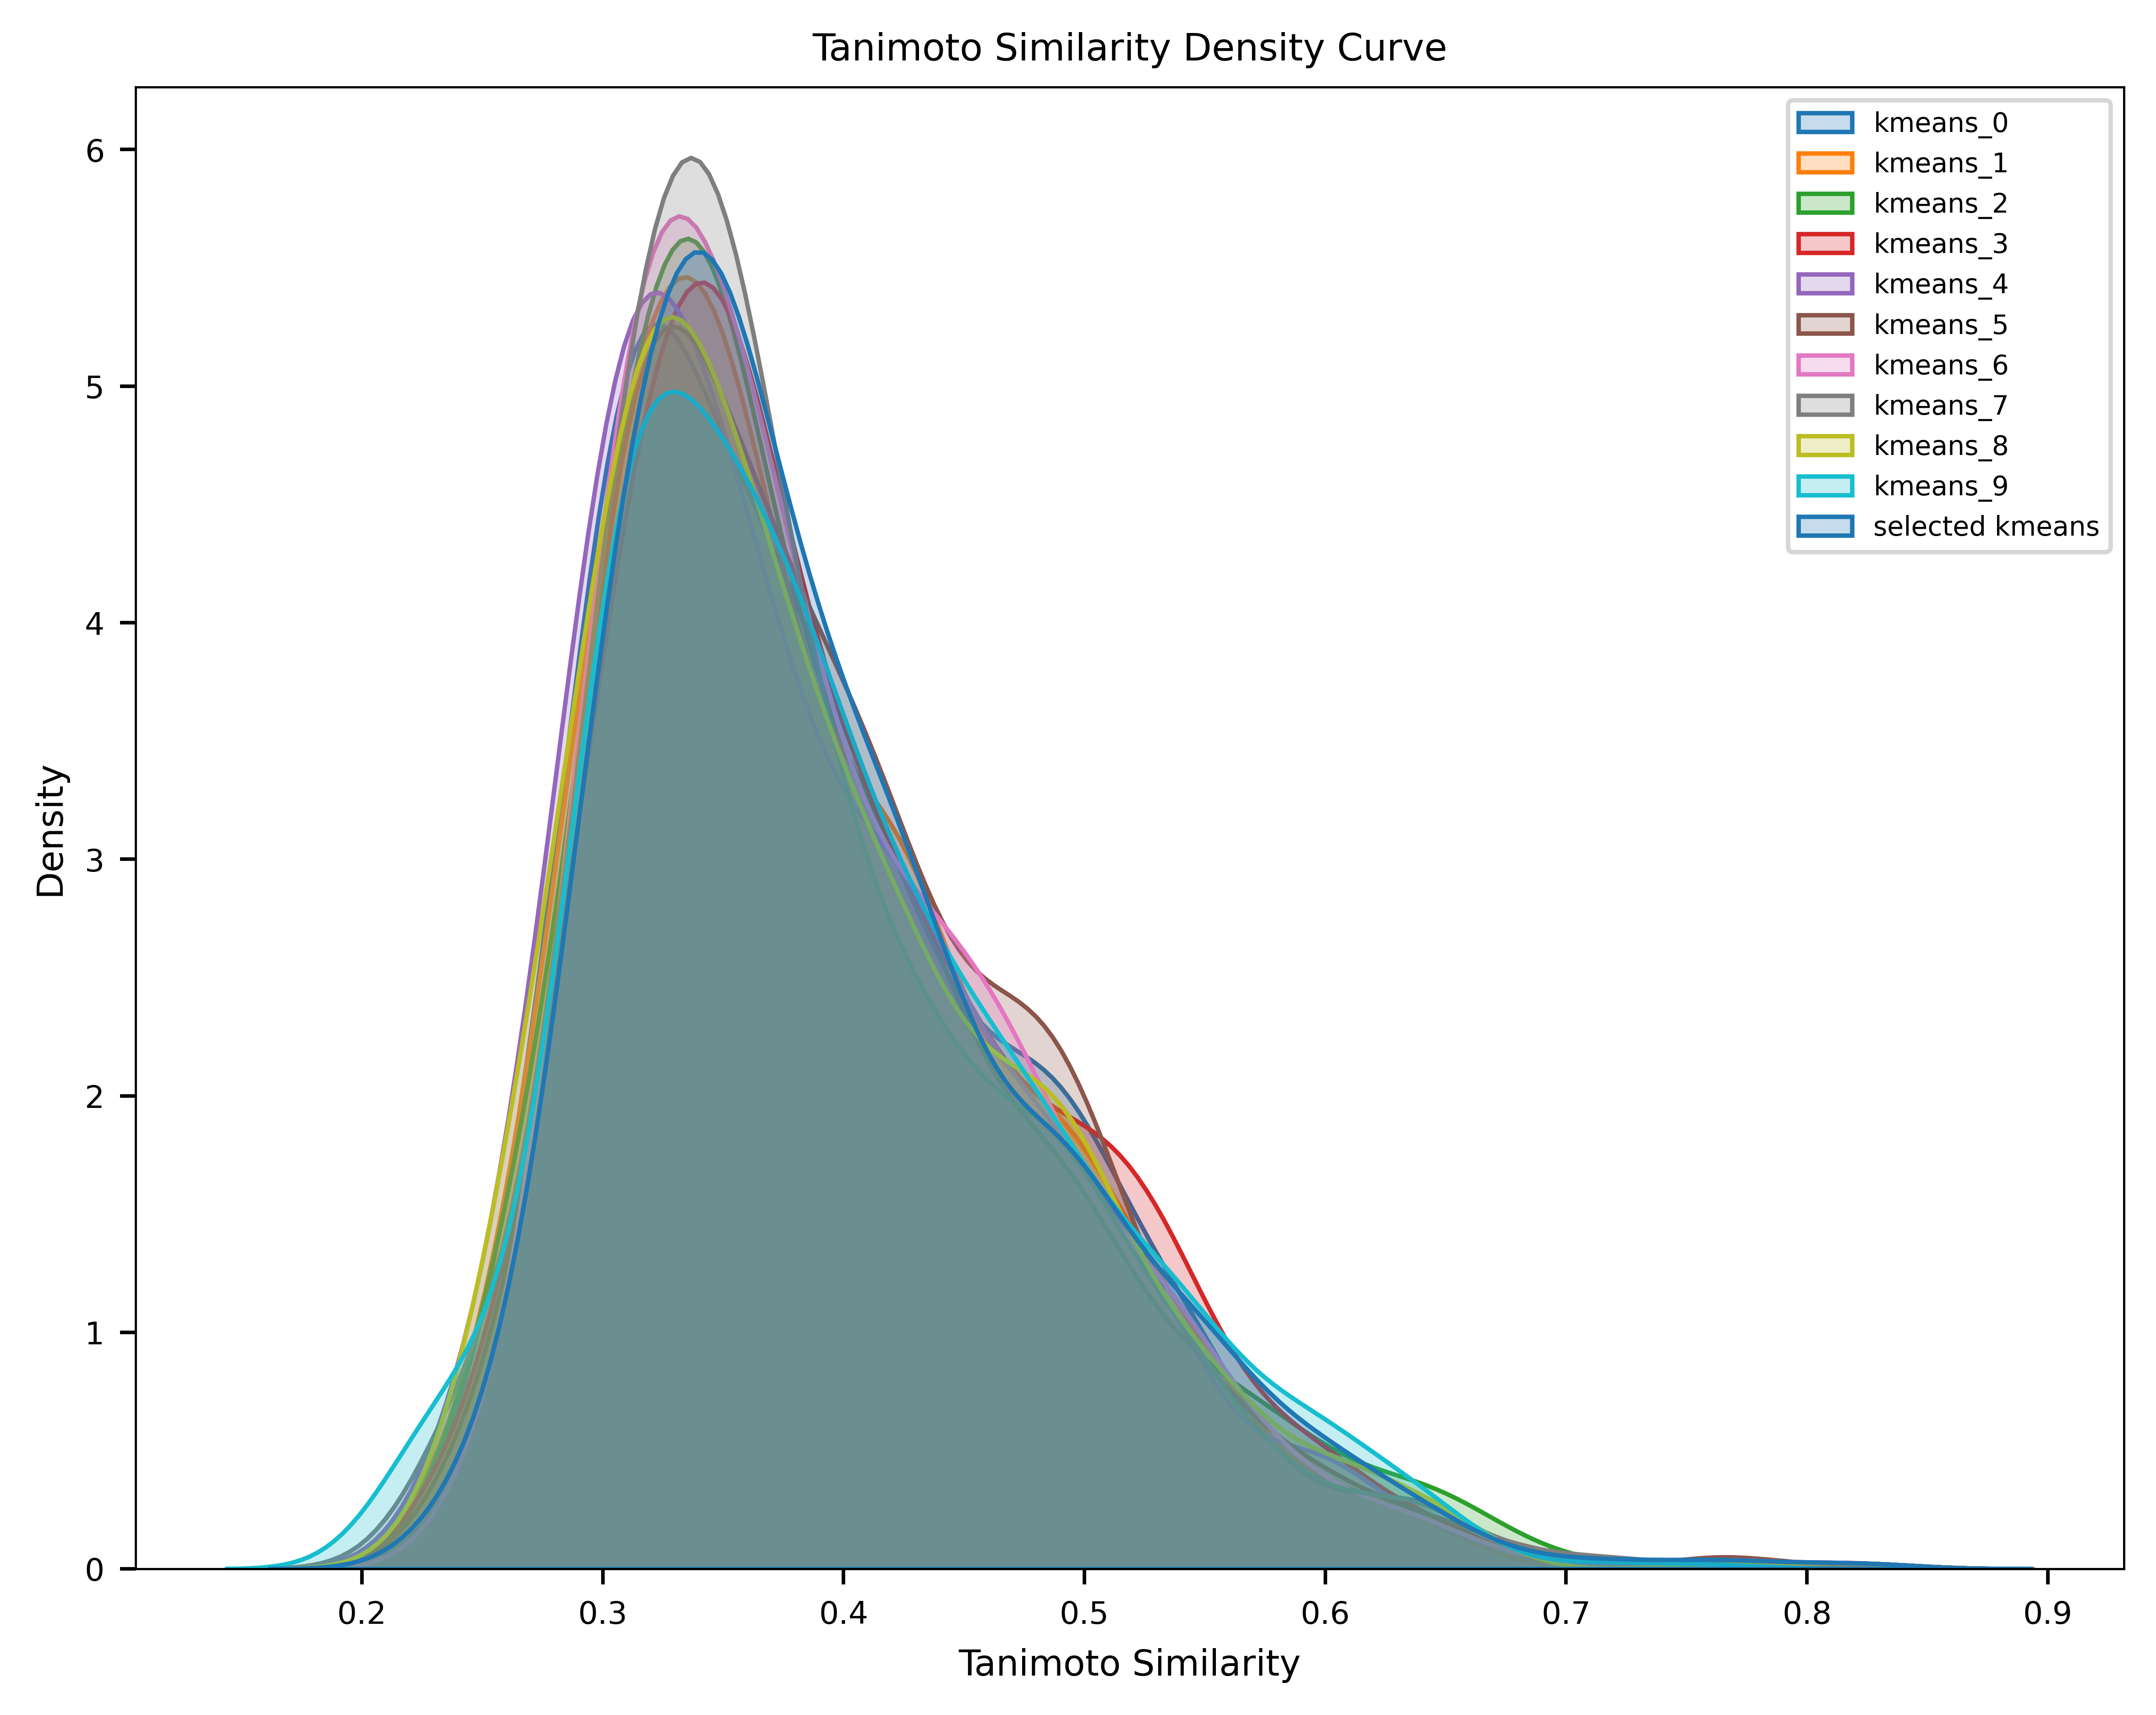

In [57]:
fig = plt.figure(figsize=(8, 6))

for col in all_kmeans.columns :
    
    smiles_list = all_kmeans[col]
    
    # Calculate Morgan fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in smiles_list]

    # Calculate Tanimoto similarities
    similarity_matrix = []
    for i in range(len(smiles_list)):
        similarities = [AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(len(smiles_list))]
        similarity_matrix.append(similarities)

    # Create a DataFrame for the similarity matrix
    df = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)

    # Flatten the upper triangle of the similarity matrix for the kernel density estimate
    flat_similarity_values = df.values[np.triu_indices(len(smiles_list), k=1)]

    # Create a density curve

    sns.kdeplot(flat_similarity_values, fill=True, label = f'{col}')
    
plt.title("Tanimoto Similarity Density Curve")
plt.xlabel("Tanimoto Similarity")
plt.legend()
plt.ylabel("Density")
plt.show()

fig.savefig("../results/chemical_space/tanimoto_similarity_ONO_kmeans.png")


In [26]:
coverage_0 = pd.read_csv('../tables/data/coverage/coverage_50_0.csv')
coverage_1 = pd.read_csv('../tables/data/coverage/coverage_50_1.csv')
coverage_2 = pd.read_csv('../tables/data/coverage/coverage_50_2.csv')
coverage_3 = pd.read_csv('../tables/data/coverage/coverage_50_3.csv')
selected_coverage=pd.read_csv('../tables/data/coverage/smiles_to_run_coverage.csv') # the 50 more represented smiles accross running the coverage algo

In [27]:
# Create a new dataframe to store the SMILES from each coverage result
all_coverage = pd.DataFrame()

# Add each coverage result as a column in the new dataframe
all_coverage["coverage_0"] = coverage_0["SMILES"]
all_coverage["coverage_1"] = coverage_1["SMILES"]
all_coverage["coverage_2"] = coverage_2["SMILES"]
all_coverage["coverage_3"] = coverage_3["SMILES"]
all_coverage["selected coverage"] = selected_coverage["SMILES"]

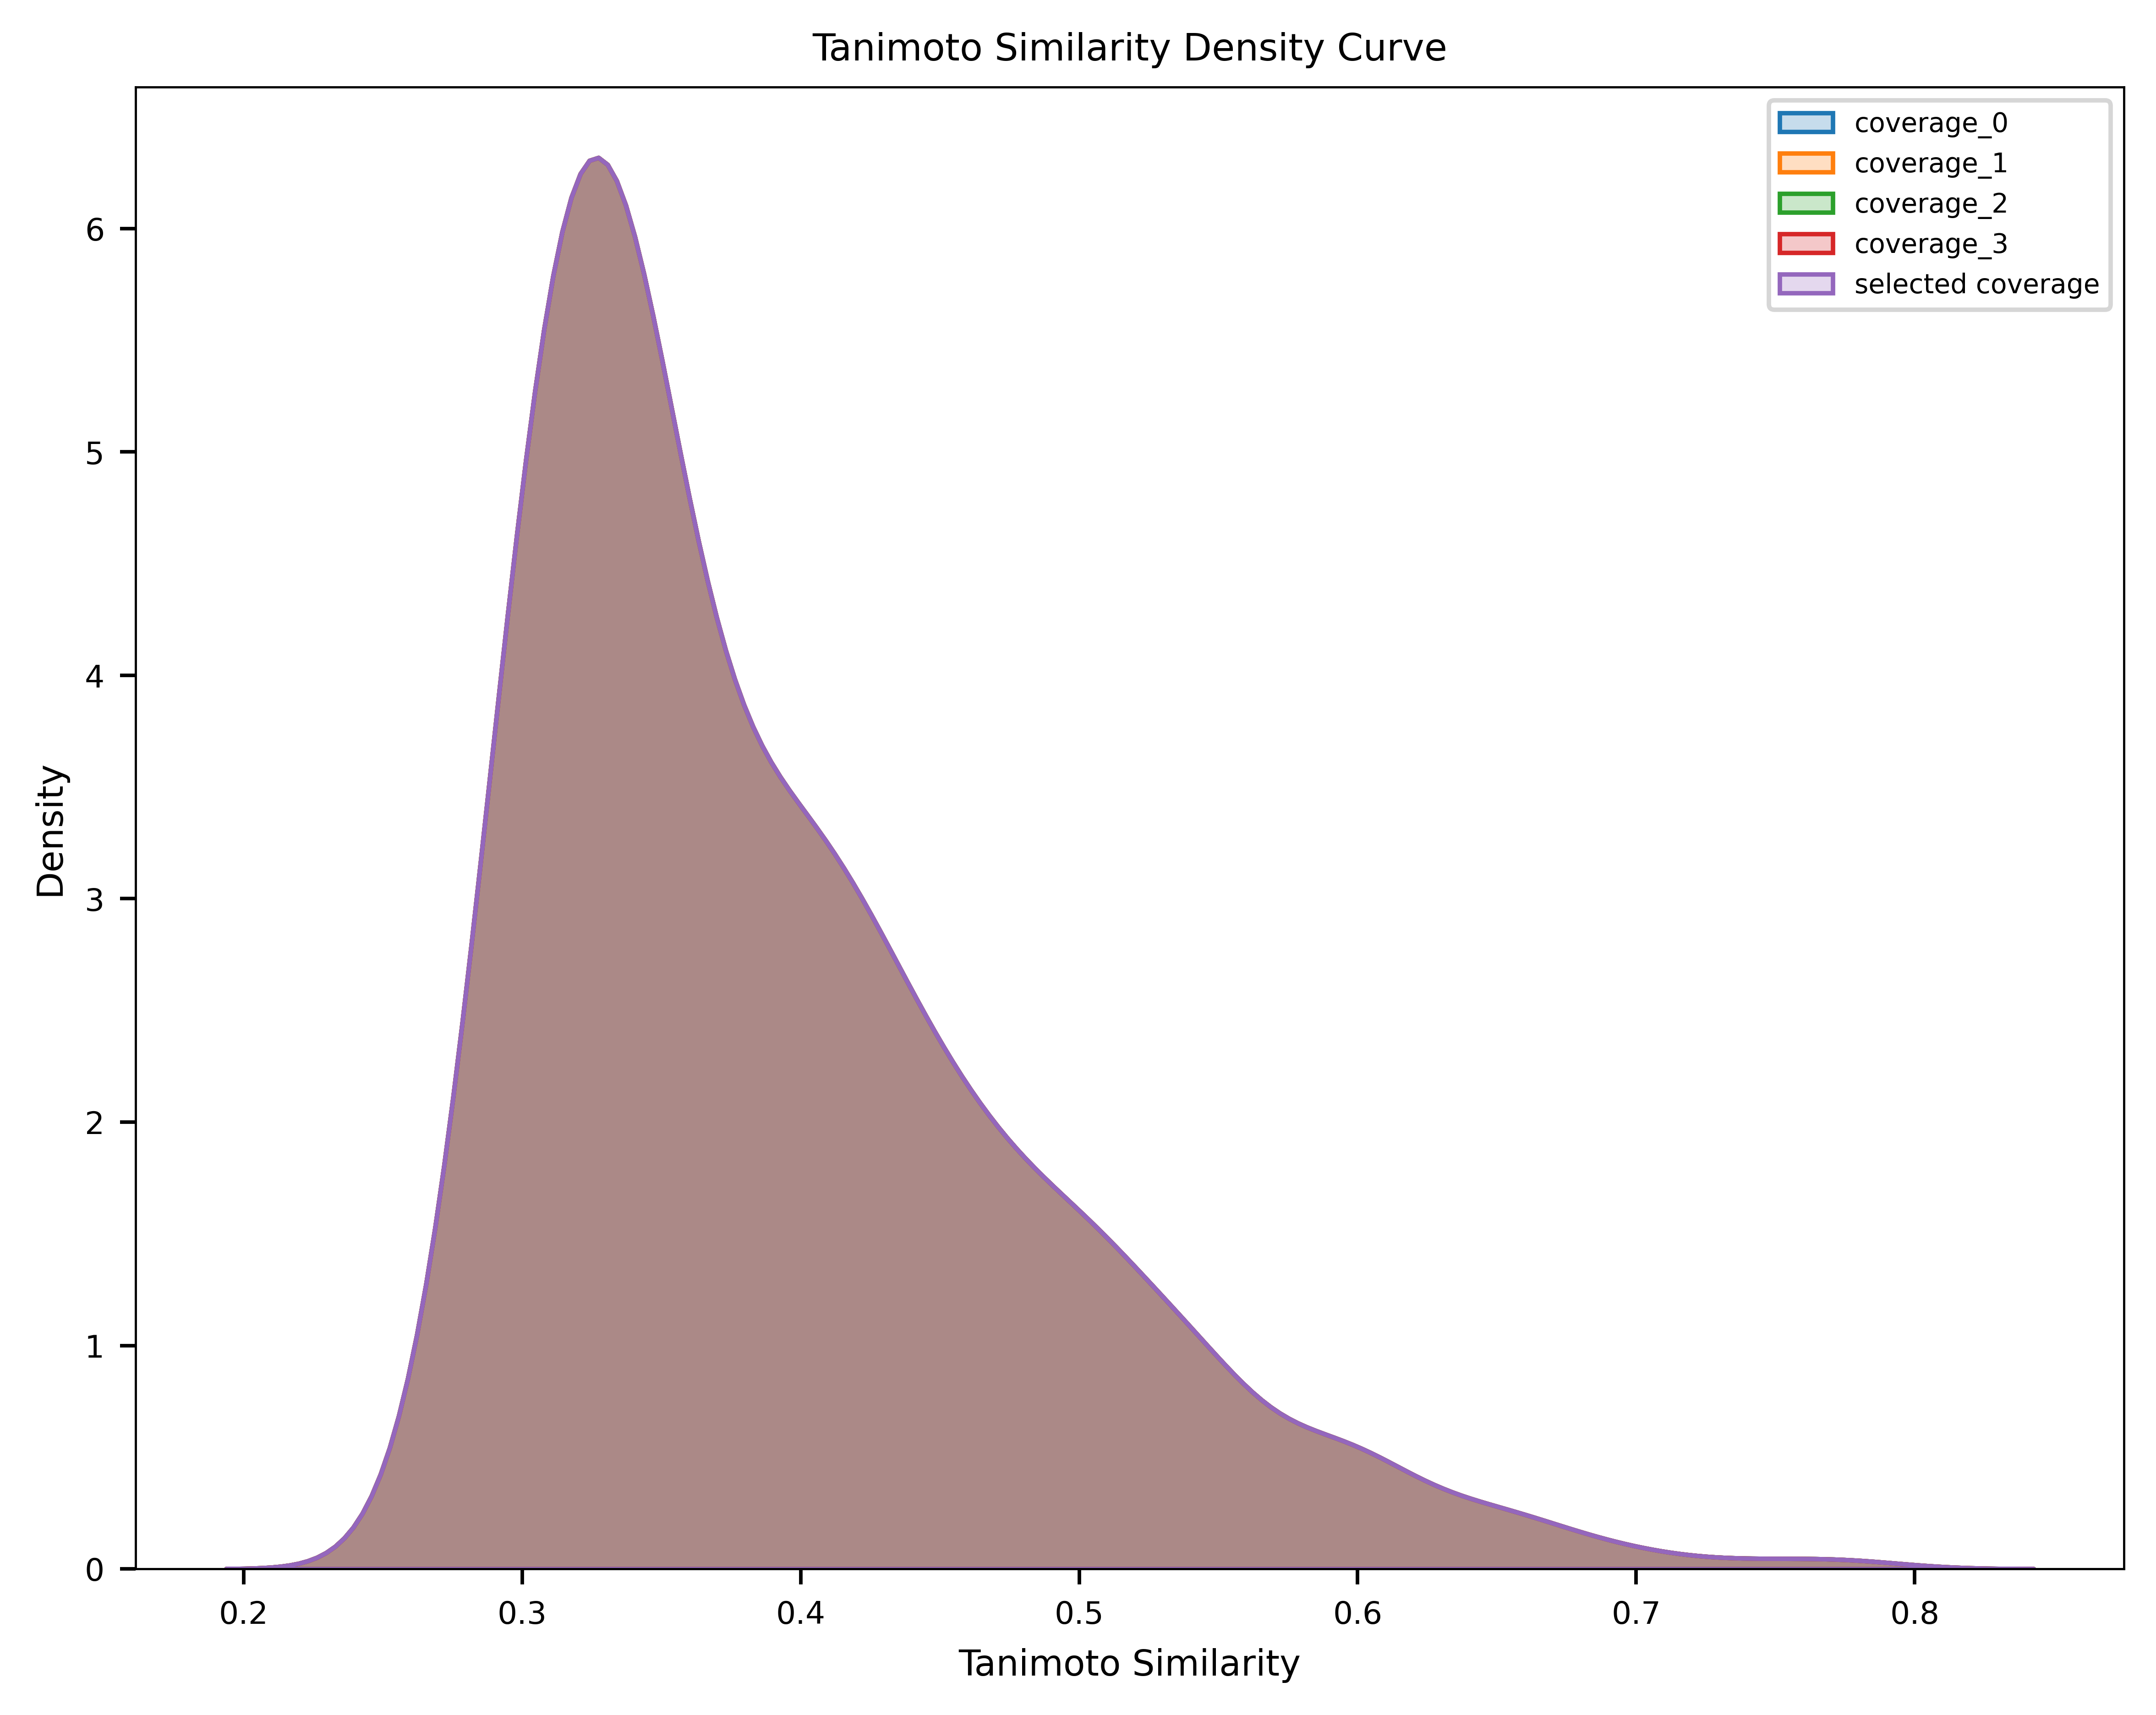

In [ ]:
fig = plt.figure(figsize=(8, 6))

for col in all_coverage.columns :
    
    smiles_list = all_coverage[col]
    
    # Calculate Morgan fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in smiles_list]

    # Calculate Tanimoto similarities
    similarity_matrix = []
    for i in range(len(smiles_list)):
        similarities = [AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(len(smiles_list))]
        similarity_matrix.append(similarities)

    # Create a DataFrame for the similarity matrix
    df = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)

    # Flatten the upper triangle of the similarity matrix for the kernel density estimate
    flat_similarity_values = df.values[np.triu_indices(len(smiles_list), k=1)]

    # Create a density curve

    sns.kdeplot(flat_similarity_values, fill=True, label = f'{col}')
    
plt.title("Tanimoto Similarity Density Curve")
plt.xlabel("Tanimoto Similarity")
plt.legend()
plt.ylabel("Density")
plt.show()

fig.savefig("../results/chemical_space/tanimoto_similarity_ONO_coverage.png")

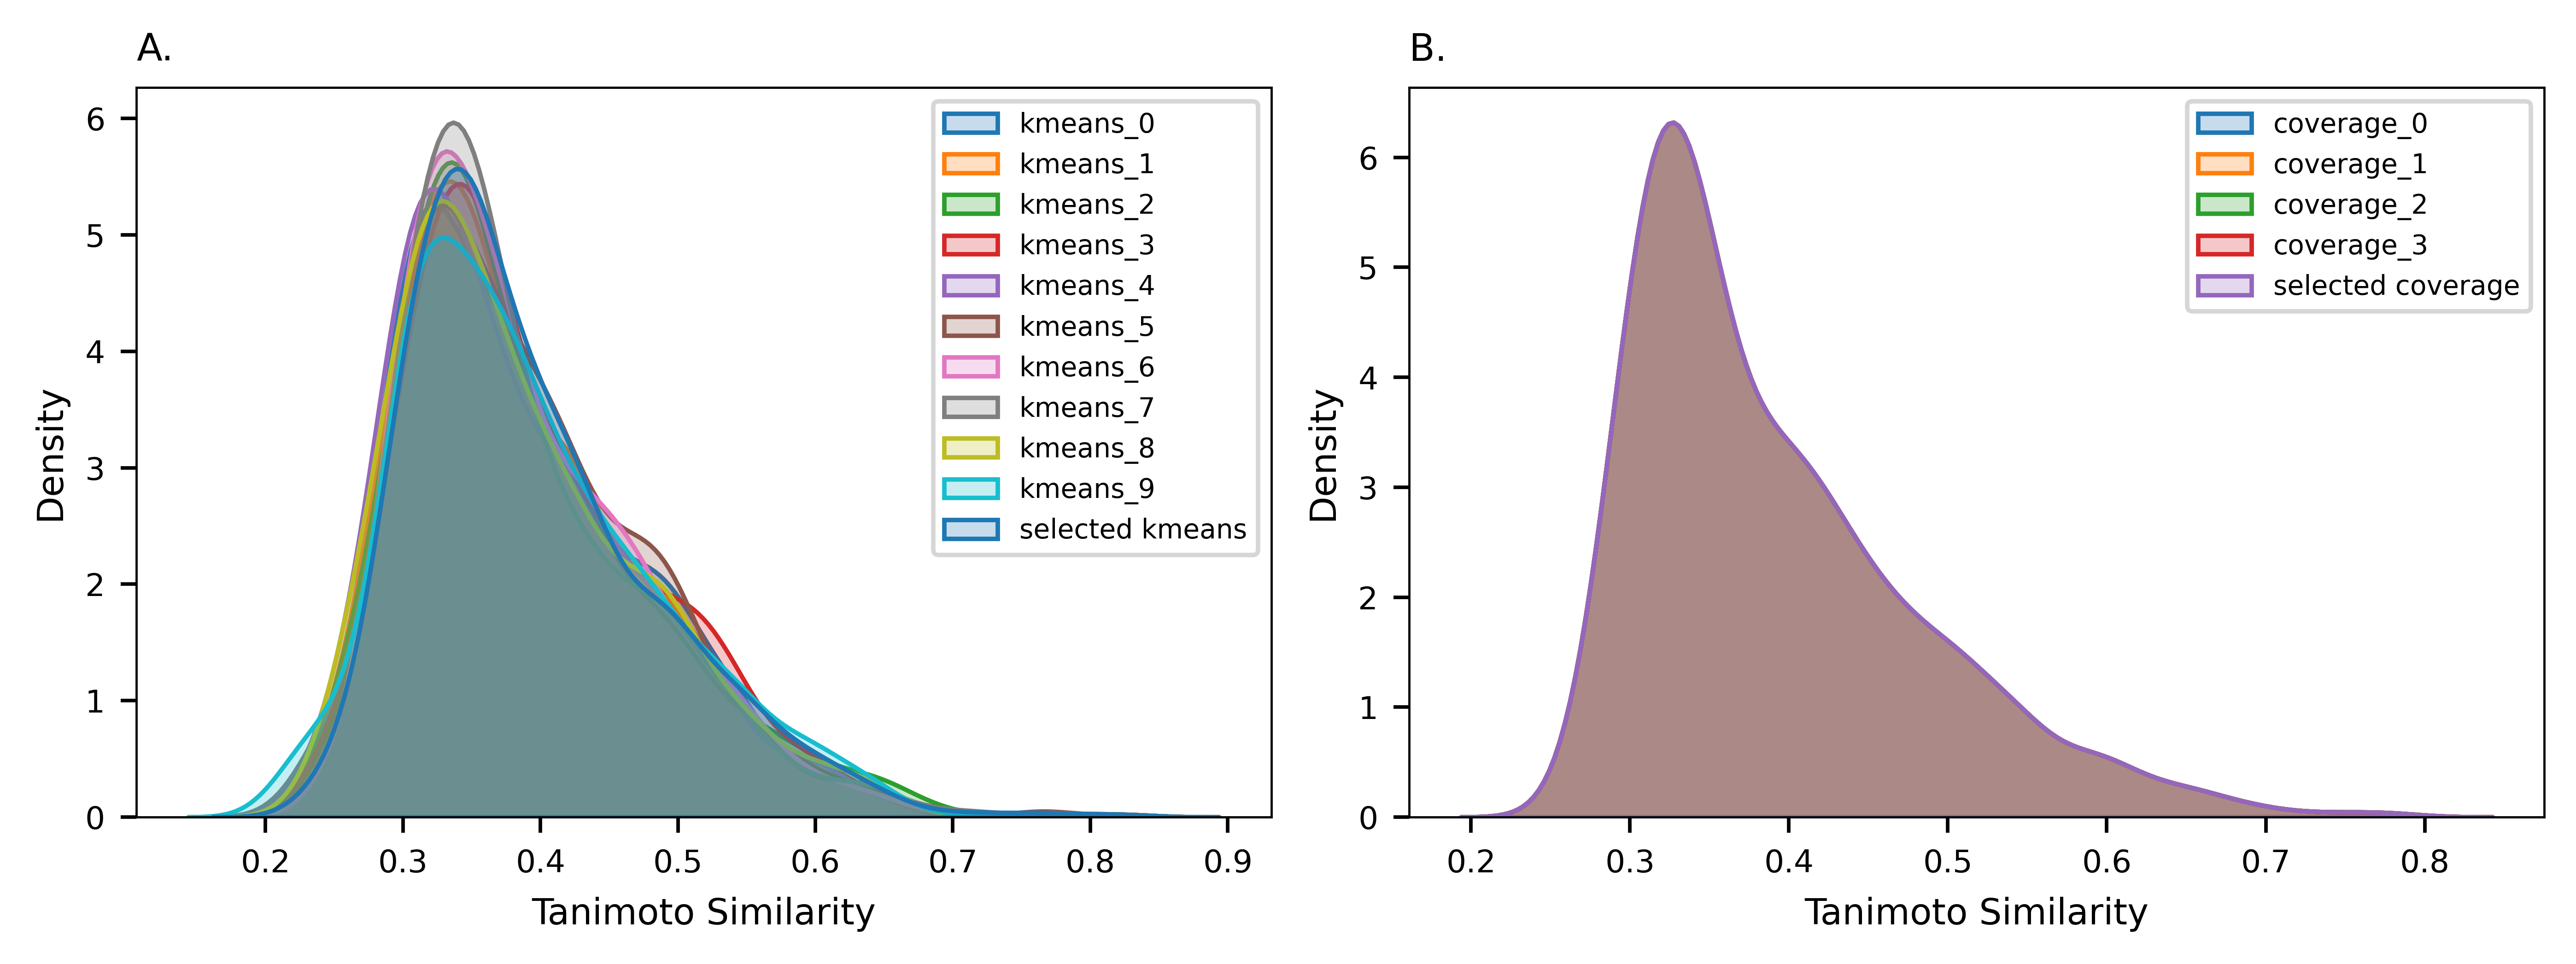

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot for all_kmeans
axes[0].set_title("A.", loc='left')
axes[0].set_xlabel("Tanimoto Similarity")
axes[0].set_ylabel("Density")

for col in all_kmeans.columns:
    smiles_list = all_kmeans[col]
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in smiles_list]
    similarity_matrix = []
    for i in range(len(smiles_list)):
        similarities = [AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(len(smiles_list))]
        similarity_matrix.append(similarities)
    df = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)
    flat_similarity_values = df.values[np.triu_indices(len(smiles_list), k=1)]
    sns.kdeplot(flat_similarity_values, fill=True, label=f'{col}', ax=axes[0])

axes[0].legend()

# Plot for all_coverage
axes[1].set_title("B.", loc='left')
axes[1].set_xlabel("Tanimoto Similarity")
axes[1].set_ylabel("Density")

for col in all_coverage.columns:
    smiles_list = all_coverage[col]
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in smiles_list]
    similarity_matrix = []
    for i in range(len(smiles_list)):
        similarities = [AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(len(smiles_list))]
        similarity_matrix.append(similarities)
    df = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)
    flat_similarity_values = df.values[np.triu_indices(len(smiles_list), k=1)]
    sns.kdeplot(flat_similarity_values, fill=True, label=f'{col}', ax=axes[1])

axes[1].legend()

plt.tight_layout()
plt.show()

fig.savefig("../results/chemical_space/tanimoto_similarity_ONO_kmeans_coverage.png",  transparent= True, facecolor='white', bbox_inches='tight')

In [31]:
df_ONO_extended = pd.read_csv('../tables/data/smiles_FIA_ONO_extended_groups.csv')

In [38]:
df_selected = df_ONO_extended[(df_ONO_extended.group == 'kmeans') | (df_ONO_extended.group == 'coverage') | (df_ONO_extended.group == 'kmeans & coverage')]

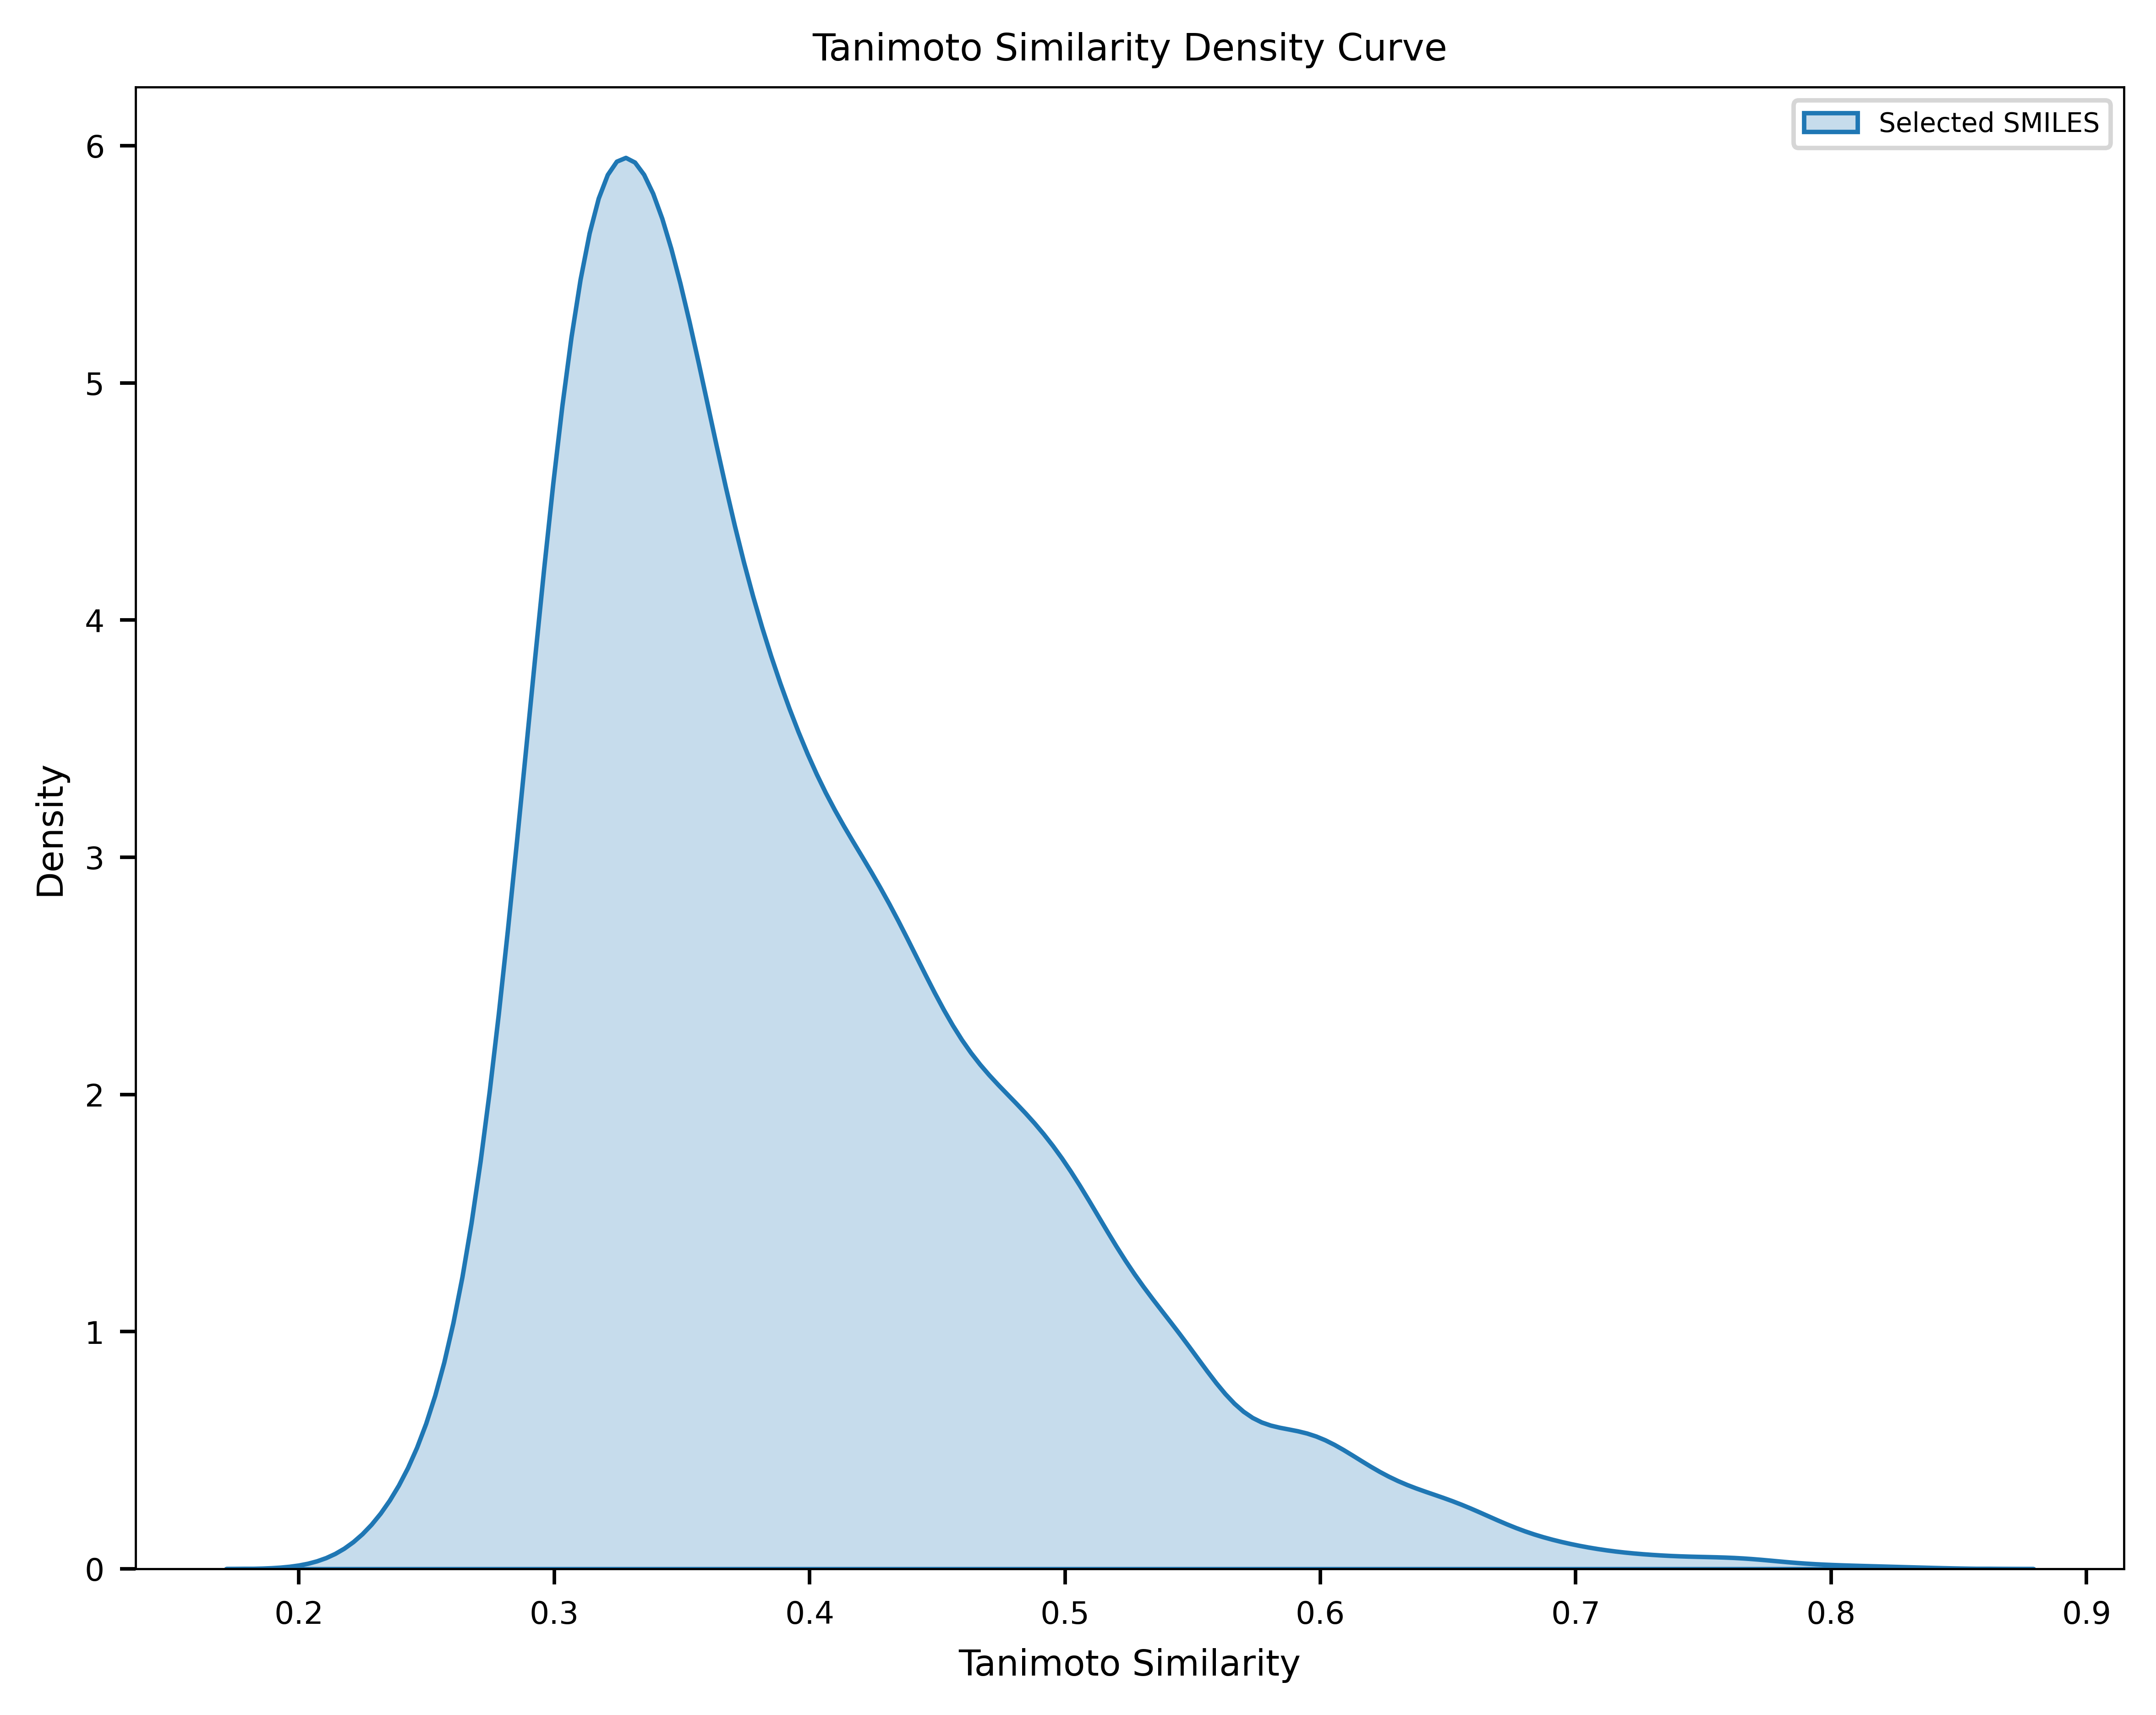

In [39]:
fig = plt.figure(figsize=(8, 6))

smiles_list = df_selected['SMILES']

# Calculate Morgan fingerprints for each molecule
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in smiles_list]

# Calculate Tanimoto similarities
similarity_matrix = []
for i in range(len(smiles_list)):
    similarities = [AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(len(smiles_list))]
    similarity_matrix.append(similarities)

# Create a DataFrame for the similarity matrix
df = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)

# Flatten the upper triangle of the similarity matrix for the kernel density estimate
flat_similarity_values = df.values[np.triu_indices(len(smiles_list), k=1)]

# Create a density curve
sns.kdeplot(flat_similarity_values, fill=True, label='Selected SMILES')

plt.title("Tanimoto Similarity Density Curve")
plt.xlabel("Tanimoto Similarity")
plt.legend()
plt.ylabel("Density")
plt.show()